# HW 2: Differentially-private Logistic Regression

In this assignment, we will implement a **differentially private** _logistic regression_ model using the **gradient clipping** technique. For this assignment, we will reuse the dataset we used for HW1, the telco customer churning dataset. The goal of this assignment is to understand the gradient clipping and its effect on a learning algorithm's performance.


## Submission instruction
- Due by 11:59pm on **Apr. 21st, 2020**
- Complete this notebook and name it as "*CSCI8960\_HW2\_{your first name}.ipynb*".
- Do **not** use any other 3rd party libraries unless you are asked to do so.
- Do **not** _hardcode_ any data.
- Feel free to modify function prototype (i.e., you can add additional input parameters or remove existing ones based on your needs)
- Feel free to define your own functions if needed.
- Label your graphs.
- All the texts and labels in your graphs should be _legible_.

As before, let's start by importing required libraries.

In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from scipy.special import expit
import matplotlib.pyplot as plt

%matplotlib inline

The pre-processed telco customer churning dataset can be dowloaded from [here](http://cobweb.cs.uga.edu/~jwlee/datasets/churn_encoded.csv). 

### Q1. (10pts) Load the dataset into a DataFrame and ensure the followings:
- add a dummy column of ones (for bias term)
- $Y \in \{-1, 1\}$
- Split the data into train and test sets 
    - 80% for training and the rest for testing

In [5]:

#-------------------------#
#  Your code goes here.   #
#-------------------------#

churn_dataset = pd.read_csv("Teleco(pre-processed).csv")
# print(churn_dataset.shape)
y = churn_dataset['Churn']

X = churn_dataset.drop("Churn",axis=1)
# print(X.shape)

encoded_y=np.empty((y.shape))
for i in range(y.shape[0]):
    if(y[i]==0):
        encoded_y[i] = -1
    else:
        encoded_y[i] = 1
        
# print(encoded_y)
        
dummy = pd.Series(np.ones((X.shape[0],)))
processed_features = pd.concat([dummy,X], axis=1)
processed_features = processed_features.rename(columns={0:'dummy'})
# print(processed_X.shape)

X_train, X_test, y_train, y_test = train_test_split(processed_features, encoded_y, test_size = 0.2)
# print(X_train)
a=X_train.to_numpy()[0]
# a=a.transpose()

Recall the objective function of _logistic regression_ model:
$$ \underset{\mathbf{\beta} \in \mathbb{R}^{p+1}}{\text{minimize}}\, \mathbb{E}[\ell(\beta)] \approx \frac{1}{n}\sum_{i=1}^n \log (1 + \exp(-y_i\mathbf{\beta}^\intercal\mathbf{x}_i))\,, $$
and its gradient is given by
$$ \frac{\partial \ell(\mathbf{\beta})}{\partial \mathbf{\beta}} = \frac{1}{n}\sum_{i=1}^n (\sigma(y_i\mathbf{\beta}^\intercal\mathbf{x}_i)-1)y_i\mathbf{x}_i\,. \qquad\qquad (1) $$

Our gradient descent algorithm performs the following updates.
- initialize starting point $\beta^{(0)}$
- given location $\beta^{(k)}$, updates the solution as follows:
    - $\beta^{(k+1)} = \beta^{(k)} - \eta_k \nabla \ell(\beta^{(k)})\,,$
    
For your convenient, here we provide a code for its objective and gradient. Look at the following code and make sure you understand what it is doing.

In [6]:
def logres_obj(X, y, beta):
    """
    returns the objective value of the logistic regression model
    
    Parameters:
    ------------
    X, y: numpy arrays representing the input dataset
    beta: numpy array correspoinding to the parameter vector
    
    Output:
    -------
    obj: objective value (scalar)
    """
    obj = np.log(1. + np.exp(-y * np.dot(X, beta)))
    loss = np.mean(obj)
    
    return loss

# test code assuming (train_X, train_y) represents your training dataset
beta = np.zeros(X_train.shape[1])
print(logres_obj(X_train, y_train, beta))

beta = np.ones(X_train.shape[1])
print(logres_obj(X_train, y_train, beta))

0.6931471805599454
8.332731580626957


In [7]:
def finite_diff_grad(X, y, beta, h=0.00001):
    """ 
    This function numerically evaluates the gradient of the objective function at beta
    """ 
    p = len(beta)
    grad = np.zeros(p)
    
    for i in range(p):
        e = np.zeros_like(beta)
        e[i] = h
        
        # evalute f(x+h)
        f_beta_h1 = logres_obj(X, y, beta+e)
        
        # evaluate f(x - h)
        f_beta_h2 = logres_obj(X, y, beta-e)
        
        grad[i] = (f_beta_h1 - f_beta_h2) / (2.0 * h)
        
    return grad

In [8]:
def logres_grad(X, y, beta):
    """
    returns the gradient of logistic regression model
    
    Parameters:
    ------------
    X, y: numpy arrays representing the input dataset
    beta: numpy array correspoinding to the parameter vector
    
    Output:
    -------
    grad: 1D numpy array
    """    
    
    z = (expit(y * np.dot(X, beta)) - 1) * y
    grad = np.mean(z.reshape(-1, 1) * X, axis=0)    
    
    return grad 


# test code
"""
The outputs of two functions, logres_grad() and finite_diff_grad(), should be 
approximately the same.
"""
grad_analytic = logres_grad(X_train, y_train, beta)
grad_numeric = finite_diff_grad(X_train, y_train, beta)

print("L2 distance=", np.linalg.norm(grad_analytic - grad_numeric))

L2 distance= 3.07064411454443e-10


### Q2. (30 pts) Implment the Gradient Clipping
Recall that the sensitivity of gradient computation can be bounded by applying the gradient clipping. Let $C$ be the clipping threshold.
1. For each $\mathbf{x}_i$ in a mini-batch $B$, compute its gradient. Let $\mathbf{g}_i$ denote the gradient.
2. Compute its $L_2$-norm, $\|\mathbf{g}_i\|_2$
3. (gradient clipping): $\overline{\mathbf{g}}_i = \begin{cases}
\frac{C}{\|\mathbf{g}_i\|_2}\mathbf{g}_i & \text{ if } \|\mathbf{g}\|_2 > C \,,\\
\mathbf{g}_i & \text{ otherwise.}
\end{cases}$
4. (noise injection step): $\widetilde{\mathbf{g}} = \sum_{i} \overline{\mathbf{g}}_i + \mathcal{N}(0, C\sigma^2)$  
5. (averaging): $\widetilde{\mathbf{g}} = \widetilde{\mathbf{g}} / |B|$   

Implement `logres_clipped_grad()` function that computes the clipped gradient

In [9]:
def logres_clipped_grad(X, y, beta, C, sigma):
    """
    returns the gradient of logistic regression model
              
    Parameters:
    ------------
    X, y: numpy arrays representing the input dataset
    beta: numpy array correspoinding to the parameter vector
    C: scalar, clipping threshold, the gradient with L2-norm larger than this value will 
       be clipped to this value
    
    Output:m
    -------
    noisy_grad: 1D numpy array
    """
    #---------------------------#
    #    Your code goes here    #
    #---------------------------#
    
#     g = logres_grad(X, y, beta)

    total_g = np.zeros((X.shape[1]))
    minibatch_x = X.to_numpy()
    minibatch_y = y

    for i in range(len(minibatch_x)):
            
        g = logres_grad(minibatch_x[i], minibatch_y[i], beta)
        g_norm = np.linalg.norm(g)
        if g_norm > C:
            clipped_g = (g*C)/g_norm
        else:
            clipped_g = g
        
        total_g = np.add(total_g,clipped_g)
    
    noisy_grad = total_g + np.random.normal(0,(C*sigma*sigma),total_g.shape[0])
    
    noisy_grad = noisy_grad / X.shape[0]
    
    return noisy_grad
    
#     return clipped_g

### Q3. (30 pts) Implement the stochastic gradient descent (SGD) algorithm.
Using the two functions `logres_obj()` and `logres_clipped_grad()`, implement the stochastic gradient descent algorithm. The core of SGD algorithm is $$\beta^{(k+1)}=\beta^{(k)}-\eta\nabla f(\beta^{(k)}, B)\,,$$
where $B$ denotes a mini-batch. Notice that the gradient evaluated over the examples in the mini-batch, rather than over the whole dataset.
$$ \nabla f(\beta, B) = \frac{1}{|B|}\sum_{i \in B} \nabla \ell(\beta, (\mathbf{x}_i, y_i))$$
The notation $|B|$ denotes the size of mini-batch, i.e., the number of examples in $B$.
1. Initialize the $\beta^{(0)} = (0, 0, \ldots, 0)^\intercal$.
2. While $k\leq \mathtt{max\_iter}$:
    - construct a mini-batch by randomly sampling $\tau=|B|$ indices, i.e., $B\subset \{0, 1, \ldots, n-1\}$, where $n$ is the size of your training dataset.
    - evaluate gradient at $\beta^{(k)}$ using the mini-batch
    - update parameter: $\beta^{(k+1)} = \beta^{(k)} - \eta\nabla f(\beta^{(k)})$

In [10]:
def dp_sgd(X, y, max_iter, C, sigma, batch_size):
    """
    differentially private stochastic gradient descent algorithm
    
    Parameters:
    ----------------
    X, y: input dataset
    max_iter: the number of iterations
    C: clipping threshold
    sigma: scale parameter of noise distribution
    batch_size: the size of mini-batch
                 
    Returns:
    -----------
    sol_path : a list of solutions, the kth entry corresponds to the beta 
               at iteration k
    obj_vals : a list of object values, the kth entry corresponds to the 
               objective value at iteration k               
    """
    sol_path = []
    obj_vals = []
    eta = 0.01       # tune this value to get the best result
    
    n, p = X.shape    
    
    # initialize your parameter vector, beta, here
    beta = np.zeros(p)
    
    for i in range(max_iter):
        
        #---------------------------#
        #    Your code goes here    #
        #---------------------------#

        minibatch_X, Dummy1, minibatch_y, Dummy2 = train_test_split(X, y, train_size = batch_size)
        beta = beta - (eta*logres_clipped_grad(minibatch_X, minibatch_y, beta, C, sigma))
        obj_vals.append(logres_obj(minibatch_X, minibatch_y, beta))
        sol_path.append(beta)
        
    return sol_path, obj_vals 

### Q4. (10 pts) Using the following prediction function, report the changes of accuracy and objective values over iterations.
- Fix the clipping threshold $C$ to 4 and test different noise scales $\sigma \in \{0.1, 1, 10, 50, 100\}$
- You can search the value of $\sigma$ that approximately gives you the similar result with non-private algorithm
- Plot the chanage of accuracy and objective values against the number of iterations for both training and test sets.

In [11]:
def predict(X, beta):
    """
    predict the labels of observations in X
    
    Parameters:
    ----------------
    beta: coefficients
    X: 2D numpy array, a set of observations, an example per row
    
    Returns:
    y_hat: predicted labels    
    """

    wx = np.dot(X , beta)
    y_hat = np.ones(X.shape[0])
    y_hat[wx < 0] = -1
    
    return y_hat

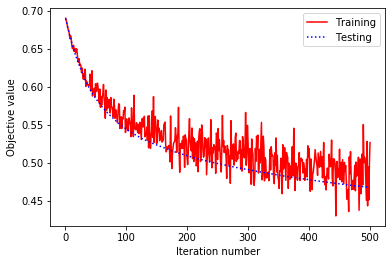

In [12]:
#---------------------------#
#    Your code goes here    #
#---------------------------#

## I got same curve with sigma = 0.1, 1 and 10.

C = 4
sigma = 0.1
batch_size=400
max_iter = 500
sols, objs_train = dp_sgd(X_train, y_train, max_iter, C, sigma, batch_size)

objs_test = []
for i in range(max_iter):
    objs_test.append(logres_obj(X_test, y_test, sols[i]))

    
x = np.linspace(1, max_iter, max_iter)
plt.plot(x, objs_train, 'r-',label='Training')
plt.plot(x, objs_test, 'b:',label='Testing')
plt.xlabel('Iteration number')
plt.ylabel('Objective value')
plt.legend()

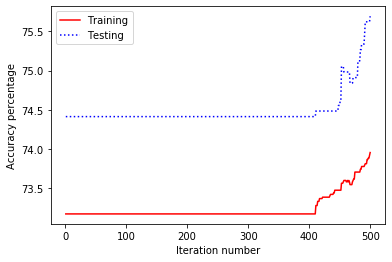

In [13]:
# Accuracy plotting

## The accuracy remains same for constant for 400 iterations and then increases. Mostly it remains in 70-75 range. 

def compute_accuracy(testX, testY, sols):
    """
    returns the accuracy of each solution on the given dataset
    
    accuracy = percentage of correctly classified examples
    
    Parameters
    -----------
    testX, testY: input dataset
    sols: a list of parameter vectors
    
    Returns
    --------
    acc: a list of accuracies, each element corresponds to the accuracy of each solution in sols
    """
    acc = []
    
    n_examples = len(testY)
    
    for sol in sols:  
        pred = predict(testX, sol)
        n_correct = n_examples - np.count_nonzero(testY - pred)
        acc.append((n_correct*100.0)/n_examples)
        
    return acc

train_accs = compute_accuracy(X_train, y_train, sols)
test_accs = compute_accuracy(X_test, y_test, sols)

x = np.linspace(1, max_iter, max_iter)
plt.plot(x, train_accs, 'r-',label='Training')
plt.plot(x, test_accs, 'b:',label='Testing')
plt.xlabel('Iteration number')
plt.ylabel('Accuracy percentage')
plt.legend()
# print(sols[len(sols)-1],sols[0])


### Q5. (10 pts) Show the effect of clipping threshold on the accuracy.
- Fix the noise level $\sigma$ to the value you found in Q4.
- Increase the value of $C$, say $[C, 2C, 4C, 5C]$. You can freely choose both the value of $C$ and the method with which you increase the value of $C$ to provide a best plot showing their relationship. Here, our goal is to show the impact of $C$ on the accuracy.

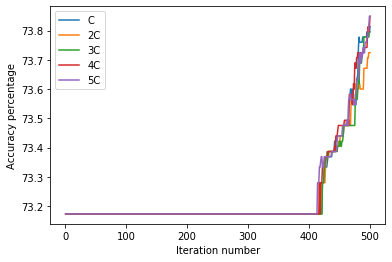

In [14]:
#---------------------------#
#    Your code goes here    #
#---------------------------#

## I get different results every time I run this. Most of the time C or 4C gives the best accuracy. 

C=4
sigma = 0.1
batch_size=200
max_iter = 500
accuracies = []


for i in range(1,6):
    threshold = i*C
    sols, objs = dp_sgd(X_train, y_train, max_iter, threshold, sigma, batch_size)  
    accuracies.append(compute_accuracy(X_train, y_train, sols))
    
x = np.linspace(1, max_iter, max_iter)
plt.plot(x, accuracies[0], label='C')
plt.plot(x, accuracies[1], label='2C')
plt.plot(x, accuracies[2], label='3C')
plt.plot(x, accuracies[3], label='4C')
plt.plot(x, accuracies[4], label='5C')
plt.xlabel('Iteration number')
plt.ylabel('Accuracy percentage')
plt.legend()


### OBSERVATIONS

- As evident from the graph, i get best results of accuracy for sigma = 1
- As evident from the second graph, i get best and consistent results for accuracy for C -> 4C = 16


### Q6. (10 pts) Show the effect of batch size on the accuracy
- Fix the noise level $\sigma$, $C$, and max\_iter (again, the choice of best value is up to you)
- Try the following batch_size $|B| \in \{1, 32, 64, 128\}$
- Plot the change of accuracy agains the iterations .
- You will have 4 different lines in your plot, each of which corresponds to a distinct batch size.

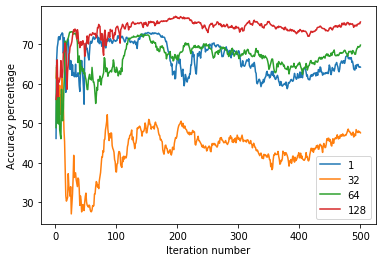

In [17]:
#---------------------------#
#    Your code goes here    #
#---------------------------#

## Here I am keeping the value of sigma to 10, to show the effect of batch size. 
## In most cases, the batch size of 128 gives best accuracy where as batch size of 1 gives the worst result
## But sometimes the result might be different. Mostly 128 and 64 does better than 32 and 1.

## When I set sigma to 0.1 or 1, I get same accuracy for all batch sizes (straight line) except for batch size of 1.
## For batch size of 1 with sigma = 0.1, it increases from very low accuracy and
## eventually increases and merges with the other lines around (73)

sigma = 10
C = 4
max_iter = 500
batch_size = [ 1, 32, 64, 128]

accuracies = []

for i in batch_size:
    sols, objs = dp_sgd(X_train, y_train, max_iter, C, sigma, i)  
    accuracies.append(compute_accuracy(X_train, y_train, sols))

x = np.linspace(1, max_iter, max_iter)
plt.plot(x, accuracies[0], label='1')
plt.plot(x, accuracies[1], label='32')
plt.plot(x, accuracies[2], label='64')
plt.plot(x, accuracies[3], label='128')
plt.xlabel('Iteration number')
plt.ylabel('Accuracy percentage')
plt.legend()

### Observation based on the graphs above
- I get pretty good performance on sigma=1 in the first graph.
- I get pretty good results for C = 4C(C=16) in the second graph.
- Finally, for the third graph, I choose sigma=1 and C=16; with the final graph giving best resuls for batchsize=128

#### **NOTE  : The optimal values keep changing everytime i run the code.**